In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df=pd.read_csv("DATASET.csv")

In [3]:
df.dtypes

,0
mileage,int64
price,int64
model_year,int64
make,object
model,object
series,object
style,object
certified,int64
price_analysis,int64
drivetrain_from_vin,object


In [4]:
df_copy=df.copy()

In [ ]:

# Function to check missing values, null values, and zero counts
def check_missing_values(df):
    missing_counts = df.isnull().sum()  # Count of missing values (NaN)
    zero_counts = (df == 0).sum()  # Count of zeros
    empty_string_counts = (df == '').sum()  # Count of empty strings
    special_missing = ['N/A', '?', '-', 'n/a']
    special_missing_values = df.isin(special_missing).sum()  # Count of special missing values

    # Create a DataFrame with the results
    result = pd.DataFrame({
        'Missing (NaN) Count': missing_counts,
        'Zero Count': zero_counts,
        'Empty String Count': empty_string_counts,
        'Special Missing Values Count': special_missing_values
    })

    return result

# Apply the function to your DataFrame
missing_values_report = check_missing_values(df_copy)

# Display the results
print(missing_values_report)

                       Missing (NaN) Count  Zero Count  Empty String Count
mileage                                  0       10175                   0
price                                    0        4340                   0
model_year                               0           0                   0
make                                     0           0                   0
model                                    0           0                   0
series                                 825           0                   0
style                                    0           0                   0
certified                                0      144156                   0
price_analysis                           0      133080                   0
drivetrain_from_vin                      0           0                   0
engine_from_vin                          0           0                   0
transmission_from_vin                    0           0                   0
fuel_type_from_vin       

In [6]:
# Get the count of unique values for each column
unique_counts = df_copy.nunique()

# Display the counts of unique values for each column
print(unique_counts)

mileage                  46874
price                    39651
model_year                  38
make                        45
model                      702
series                    1630
style                      664
certified                    2
price_analysis               2
drivetrain_from_vin          4
engine_from_vin            974
transmission_from_vin        4
fuel_type_from_vin           7
number_price_changes       120
stock_type                   2
dtype: int64


In [7]:
df_copy['transmission_from_vin'].value_counts()

,count
transmission_from_vin,
A,141105
M,3975
7,32
6,2


In [8]:
# Convert column to string explicitly before replacing values
df_copy['transmission_from_vin'] = df_copy['transmission_from_vin'].astype(str).replace({'7': 'A', '6': 'M'})

# Check unique values after replacement
df_copy['transmission_from_vin'].unique()


array(['A', 'M'], dtype=object)

In [9]:
# fillig Null values with mode imputation
df_copy['series'] = df_copy['series'].fillna(df_copy['series'].mode()[0])


# Verify if null values are removed
print(df_copy['series'].isnull().sum())  # Should print 0


0


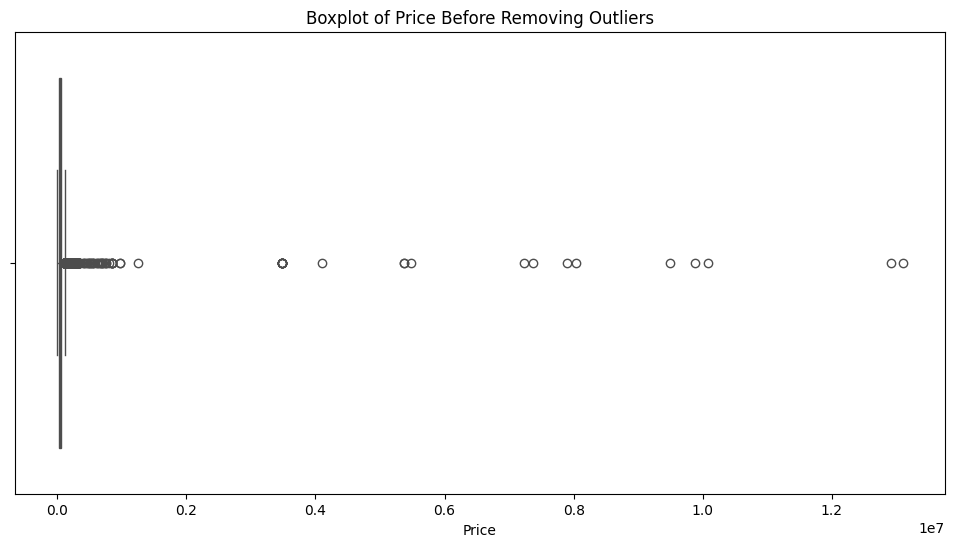

In [10]:
# Plot before removing outliers
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_copy['price'], color='red')
plt.title("Boxplot of Price Before Removing Outliers")
plt.xlabel("Price")
plt.show()

In [11]:
# Step 1: Replace mileage for 'NEW' cars with 0
df_copy.loc[df_copy['stock_type'] == 'NEW', 'mileage'] = 0

# Step 2: Calculate the median mileage for used vehicles (ignoring zero mileage)
median_mileage = df_copy.loc[df_copy['stock_type'] == 'USED', 'mileage']
median_mileage = median_mileage[median_mileage > 0].median()

# Step 3: Replace zero mileage for used cars with the calculated median
df_copy.loc[(df_copy['stock_type'] == 'USED') & (df_copy['mileage'] == 0), 'mileage'] = median_mileage

# Verify the changes
print("Count of Zero Mileage in Used Cars:")
print(df_copy[df_copy['mileage'] == 0]['stock_type'].value_counts())
print("\nUpdated Descriptive Statistics for Mileage:")
print(df_copy['mileage'].describe())



Count of Zero Mileage in Used Cars:
stock_type
NEW    68143
Name: count, dtype: int64

Updated Descriptive Statistics for Mileage:
count    1.451140e+05
mean     4.592234e+04
std      6.231858e+04
min      0.000000e+00
25%      0.000000e+00
50%      9.365000e+03
75%      8.011175e+04
max      1.000008e+06
Name: mileage, dtype: float64


In [12]:
import pandas as pd

def detect_outliers_iqr(df_copy, columns):
    """Detect outliers using the IQR method for multiple columns."""
    outlier_counts = {}

    for col in columns:
        if df_copy[col].dtype in ['int64', 'float64']:  # Check only numeric columns
            Q1 = df_copy[col].quantile(0.25)
            Q3 = df_copy[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = df_copy[(df_copy[col] < lower_bound) | (df_copy[col] > upper_bound)]
            outlier_counts[col] = outliers.shape[0]

    return outlier_counts

# Check if the 'price' column exists in the DataFrame
if 'price' in df_copy.columns:
    # Select numeric columns you want to check for outliers
    numeric_columns = ['mileage', 'price', 'model_year', 'number_price_changes']

    # Apply the function
    outliers_dict = detect_outliers_iqr(df_copy, numeric_columns)

    # Display outlier counts
    for col, count in outliers_dict.items():
        print(f"Number of outliers in '{col}' column: {count}")
else:
    print("The 'price' column is missing from the DataFrame.")



Number of outliers in 'mileage' column: 4066
Number of outliers in 'price' column: 3232
Number of outliers in 'model_year' column: 5517
Number of outliers in 'number_price_changes' column: 18786


In [13]:
def cap_outliers(df_copy, column):
    """Cap outliers in a specific column based on IQR."""
    Q1 = df_copy[column].quantile(0.25)
    Q3 = df_copy[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap values that are below the lower bound or above the upper bound
    df_copy[column] = df_copy[column].clip(lower=lower_bound, upper=upper_bound)

    return df_copy

# Apply capping to each column
df_copy = cap_outliers(df_copy, 'mileage')
df_copy = cap_outliers(df_copy, 'price')
df_copy = cap_outliers(df_copy, 'model_year')
df_copy = cap_outliers(df_copy, 'number_price_changes')

# Check the cleaned data
print(df_copy[['mileage', 'price', 'model_year', 'number_price_changes']].describe())


             mileage          price     model_year  number_price_changes
count  145114.000000  145114.000000  145114.000000         145114.000000
mean    44611.172773   46318.042505    2021.508814              2.138291
std     57708.808722   26662.986150       3.064938              2.673191
min         0.000000       0.000000    2014.000000              0.000000
25%         0.000000   26990.000000    2020.000000              0.000000
50%      9365.000000   41900.000000    2023.000000              1.000000
75%     80111.750000   62770.250000    2024.000000              3.000000
max    200279.375000  116440.625000    2024.000000              7.500000


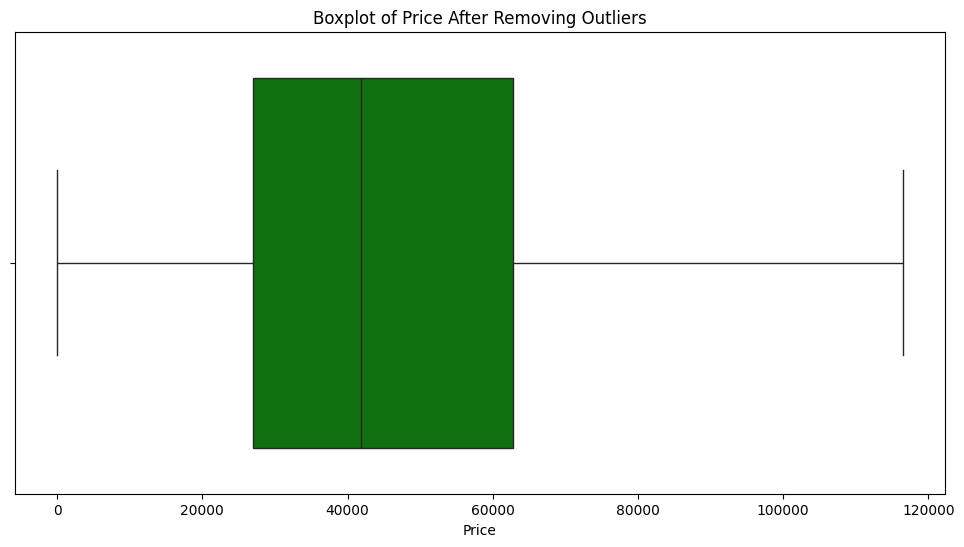

In [14]:
# Plot after removing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_copy['price'], color='green')
plt.title("Boxplot of Price After Removing Outliers")
plt.xlabel("Price")
plt.show()

After capping the outliers, the data looks cleaner and more consistent:

Mileage: The minimum is still 0 km (probably new cars or missing data), and the maximum is 200,279.38 km, which is high but within the adjusted limit. Most cars have mileage between 0 and 80,111 km.

Price: The minimum price is 0, likely due to errors or missing values. The maximum price is 116,440.63, which is high but capped. Most cars are priced between 26,990 and 62,770.

Model Year: The model years now range from 2014 to 2024, showing that the cars are mostly new.

Price Changes: The number of price changes is capped at 7.5, and most cars have between 0 and 3 price changes, with an average of around 2.

In simple terms, the capping method fixed the extreme values, so the data is now more reasonable and easier to work with.

In [15]:
df_clean_dulpicated_sum = {f"The number of duplicated rows are: {df_copy.duplicated().sum()}"}  # Replace df_clean with df_copy
print(df_clean_dulpicated_sum)

{'The number of duplicated rows are: 36426'}


In [16]:
df_copy.shape

(145114, 15)

In [17]:
df_copy.drop_duplicates(inplace=True)

In [18]:
df_copy.shape

(108688, 15)

In [19]:
#reset the row index for the dataset
df_copy_unique= df_copy.reset_index(drop=True)

In [20]:
# Import the necessary module
import matplotlib.pyplot as plt
import seaborn as sns # Import the seaborn library


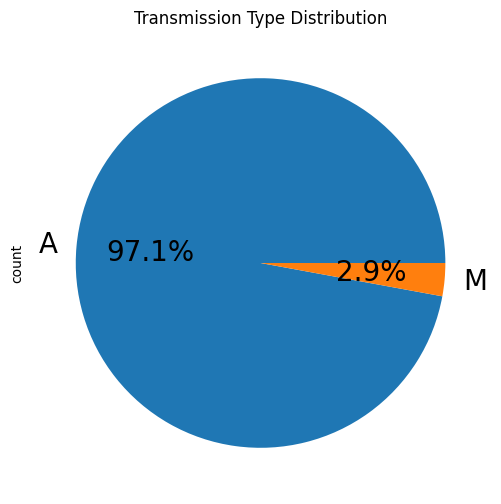

In [21]:
# Calculate transmission counts
transmission_counts = df_copy_unique['transmission_from_vin'].value_counts()

# Generate pie chart
transmission_counts.plot.pie(figsize=(6, 6), autopct='%1.1f%%', fontsize=20, subplots=True)
plt.title("Transmission Type Distribution")
plt.show()

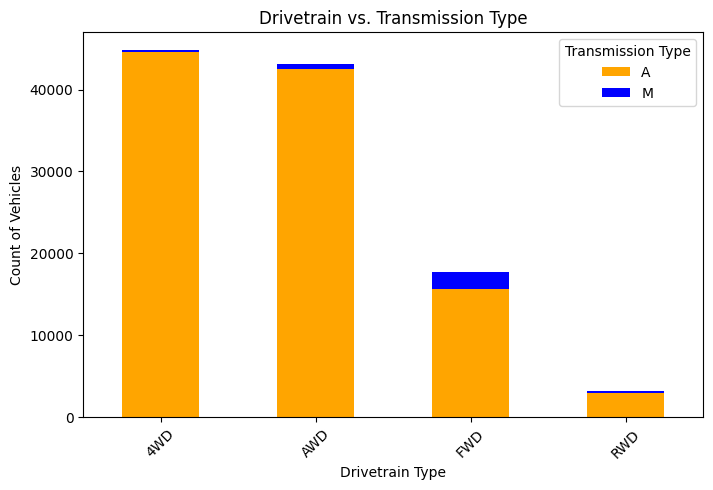

In [22]:
# Count occurrences of each transmission type within drivetrain categories
drivetrain_counts = df_copy.groupby(['drivetrain_from_vin', 'transmission_from_vin']).size().unstack(fill_value=0) # Change 'Transmission' to 'transmission_from_vin'
# Plot stacked bar chart
drivetrain_counts.plot(kind='bar', stacked=True, figsize=(8, 5), color=['orange', 'blue'])
plt.title("Drivetrain vs. Transmission Type")
plt.xlabel("Drivetrain Type")
plt.ylabel("Count of Vehicles")
plt.legend(title="Transmission Type")
plt.xticks(rotation=45)
plt.show()

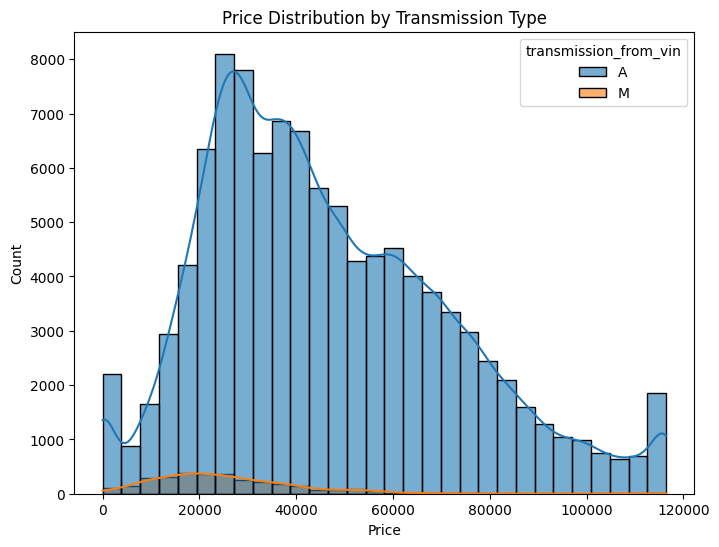

In [23]:
plt.figure(figsize=(8, 6))
sns.histplot(df_copy, x='price', hue='transmission_from_vin', bins=30, kde=True, alpha=0.6)
plt.title("Price Distribution by Transmission Type")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

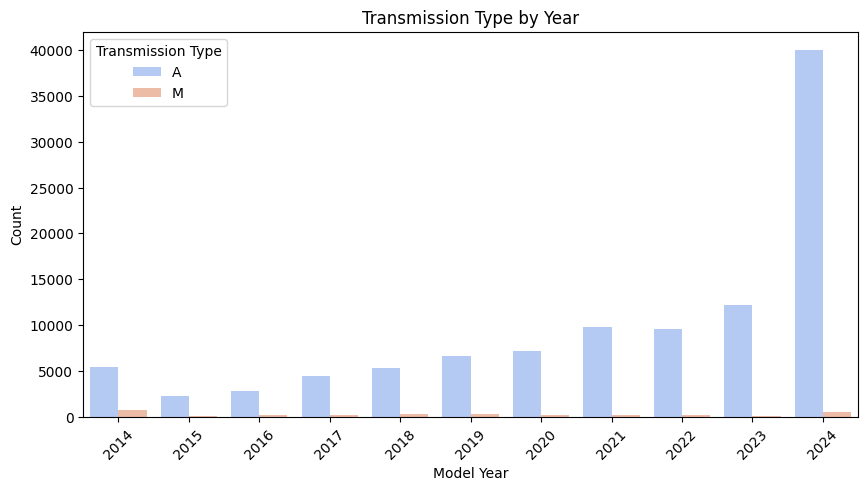

In [24]:
filtered_df = df_copy[df_copy['model_year'] >= 2005]

plt.figure(figsize=(10, 5))
sns.countplot(x="model_year", hue="transmission_from_vin", data=filtered_df, palette="coolwarm")
plt.title("Transmission Type by Year")
plt.xlabel("Model Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Transmission Type")
plt.show()

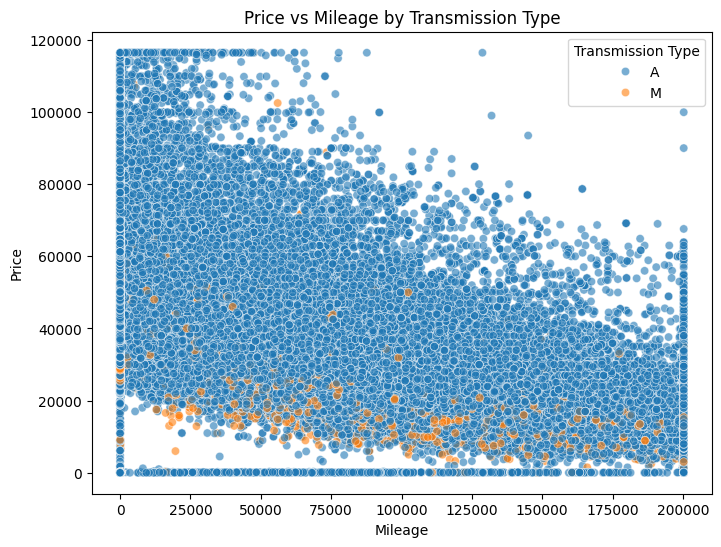

In [25]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_copy, x='mileage', y='price', hue='transmission_from_vin', alpha=0.6)
plt.title('Price vs Mileage by Transmission Type')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.legend(title='Transmission Type')
plt.show()

<ipython-input-26-bda2b2a5f6f0>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_prices.index, y=avg_prices.values, palette="rocket")


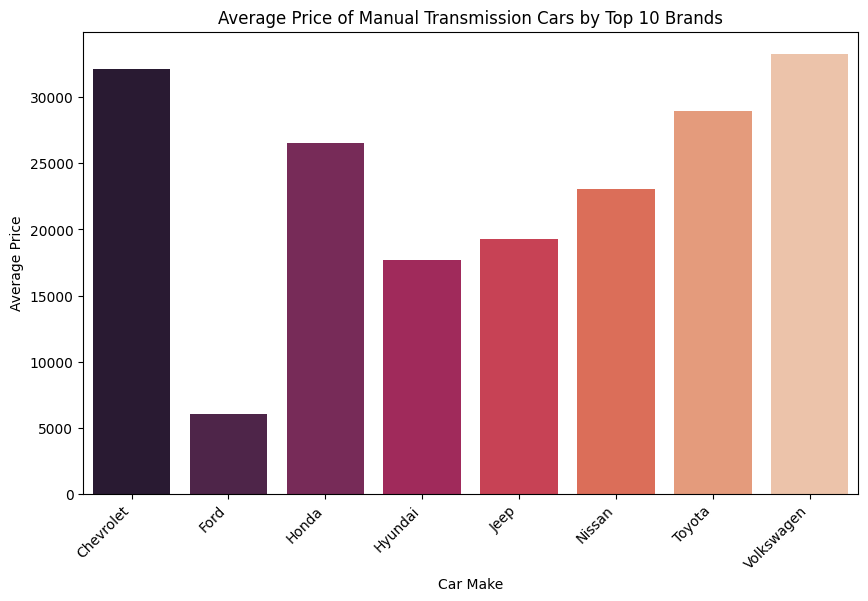

In [26]:
# Filter for top 10 brands and manual transmissions
top_10_makes = df_copy['make'].value_counts().nlargest(10).index
manual_df = df_copy[df_copy['make'].isin(top_10_makes) & (df_copy['transmission_from_vin'] == 'M')]

# Compute average prices
avg_prices = manual_df.groupby('make')['price'].mean()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_prices.index, y=avg_prices.values, palette="rocket")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Car Make")
plt.ylabel("Average Price")
plt.title("Average Price of Manual Transmission Cars by Top 10 Brands")
plt.show()

<ipython-input-27-00e2e559fe5b>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_prices.index, y=avg_prices.values, palette="rocket")


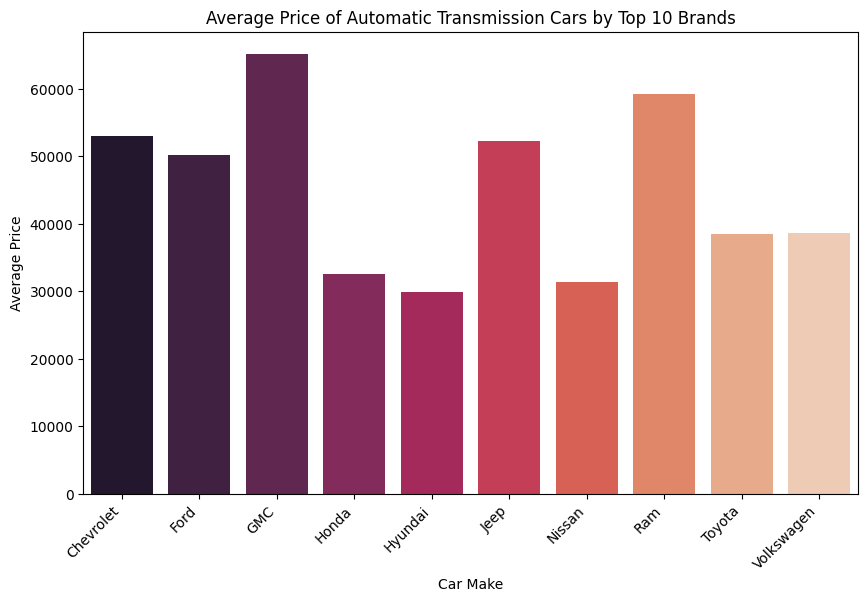

In [27]:
# Filter for top 10 brands and automatic transmissions
top_10_makes = df_copy['make'].value_counts().nlargest(10).index
auto_df = df_copy[df_copy['make'].isin(top_10_makes) & (df_copy['transmission_from_vin'] == 'A')]

# Compute average prices
avg_prices = auto_df.groupby('make')['price'].mean()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_prices.index, y=avg_prices.values, palette="rocket")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Car Make")
plt.ylabel("Average Price")
plt.title("Average Price of Automatic Transmission Cars by Top 10 Brands")
plt.show()

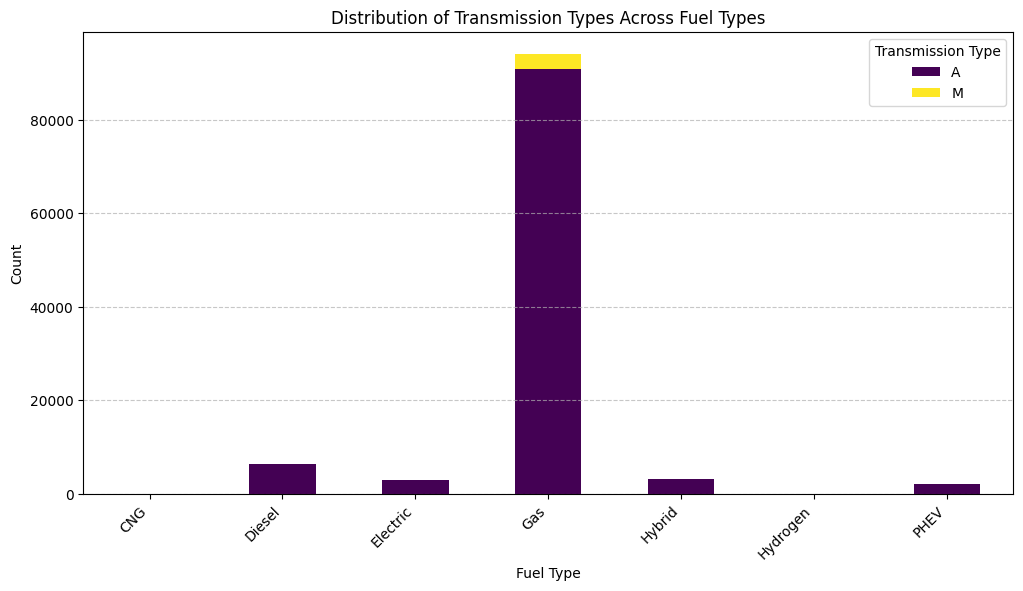

In [28]:
# Filter relevant columns
df_filtered = df_copy[['fuel_type_from_vin', 'transmission_from_vin']]

# Count occurrences for each combination
transmission_counts = df_filtered.groupby(['fuel_type_from_vin', 'transmission_from_vin']).size().unstack(fill_value=0)

# Plot a stacked bar chart
transmission_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')

# Labels and title
plt.xlabel("Fuel Type")
plt.ylabel("Count")
plt.title("Distribution of Transmission Types Across Fuel Types")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Transmission Type")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

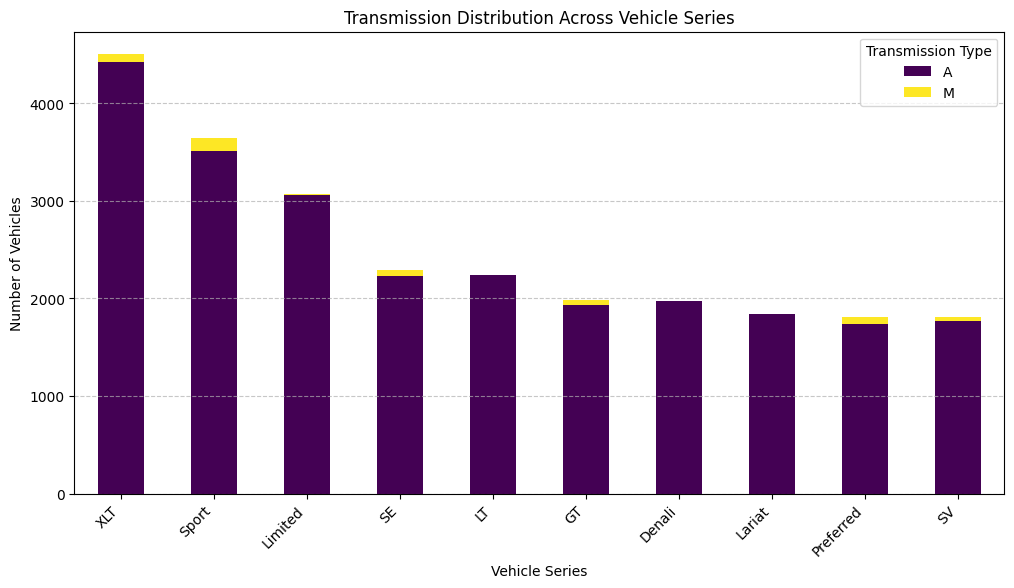

In [29]:
# Filter relevant columns
df_filtered = df_copy[['series', 'transmission_from_vin']].dropna()

# Count occurrences of each transmission type per series
series_transmission_counts = df_filtered.groupby(['series', 'transmission_from_vin']).size().unstack(fill_value=0)

# Select top 10 most common series for better visualization
top_10_series = df_filtered['series'].value_counts().nlargest(10).index
series_transmission_counts = series_transmission_counts.loc[top_10_series]

# Plot stacked bar chart
series_transmission_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')

# Labels and title
plt.xlabel("Vehicle Series")
plt.ylabel("Number of Vehicles")
plt.title("Transmission Distribution Across Vehicle Series")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Transmission Type")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

In [30]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Assuming df_copy is your DataFrame with the relevant columns
# Splitting the data into features (X) and target (y)
X = df_copy.drop(columns=['transmission_from_vin'])  # Features (all columns except target)
y = df_copy['transmission_from_vin']  # Target column

# Print initial data shapes
print("Original X shape:", X.shape)
print("Original y shape:", y.shape)

# Split data into train and test sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the shapes of train and test data after split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Now apply encoding:

# One-Hot Encoding for categorical columns in X_train and X_test
categorical_cols = ['make', 'model', 'series', 'style', 'drivetrain_from_vin', 'fuel_type_from_vin']  # Add more categorical columns as needed
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)  # Drop first to avoid multicollinearity
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Print out the first few rows of the encoded data
print("Encoded X_train head:")
print(X_train.head())

print("Encoded X_test head:")
print(X_test.head())

# Align the columns in X_train and X_test (in case some categories are missing in the test set)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Print the columns after alignment
print("Aligned X_train columns:", X_train.columns)
print("Aligned X_test columns:", X_test.columns)

# Label Encoding for the target 'transmission_from_vin'
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Print the first few transformed target values
print("y_train values after encoding:", y_train[:10])
print("y_test values after encoding:", y_test[:10])

# Now you can proceed with training the model using X_train and y_train, and testing it with X_test and y_test


Original X shape: (108688, 14)
Original y shape: (108688,)
X_train shape: (76081, 14)
X_test shape: (32607, 14)
y_train shape: (76081,)
y_test shape: (32607,)
Encoded X_train head:
         mileage    price  model_year  certified  price_analysis  \
78104        0.0  52995.0        2023          0               0   
44553   162375.0  31939.0        2021          0               0   
121007       0.0  66708.0        2024          0               0   
79461        0.0  60100.0        2023          0               1   
62839    45751.0  29399.0        2022          0               0   

                  engine_from_vin  number_price_changes stock_type  \
78104       3.6L V6 SMPI DOHC VVT                   7.5        NEW   
44553         3.6L V6 DI DOHC VVT                   1.0       USED   
121007  2.0L I-4 DI DOHC PHEV TC                    7.5        NEW   
79461          5.7L V8 SMPI Hemi                    0.0        NEW   
62839            2.4L I-4 DI DOHC                   3.0     

The code prepares the data for machine learning by:

Splitting the data into input features (X) and the target variable (y).
Dividing the data into training and testing sets.
Converting categorical data (like car make, model) into numbers using one-hot encoding.
Transforming the target variable (transmission type) into numeric values using label encoding.
Aligning the columns between training and testing data to ensure consistency.
Then, you can use this processed data to train and test a machine learning model.

In [34]:

print("Number of columns after encoding:", X_train.shape[1])

Number of columns after encoding: 2886


In [33]:
print("Columns after encoding:", X_train.columns)

Columns after encoding: Index(['mileage', 'price', 'model_year', 'certified', 'price_analysis',
       'engine_from_vin', 'number_price_changes', 'stock_type',
       'make_Alfa Romeo', 'make_Audi',
       ...
       'style_Wagon V6 SWB', 'drivetrain_from_vin_AWD',
       'drivetrain_from_vin_FWD', 'drivetrain_from_vin_RWD',
       'fuel_type_from_vin_Diesel', 'fuel_type_from_vin_Electric',
       'fuel_type_from_vin_Gas', 'fuel_type_from_vin_Hybrid',
       'fuel_type_from_vin_Hydrogen', 'fuel_type_from_vin_PHEV'],
      dtype='object', length=2886)


In [35]:
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and target data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the number of samples in each set
print("Number of samples in X_train:", X_train.shape[0])
print("Number of samples in X_test:", X_test.shape[0])
print("Number of samples in y_train:", y_train.shape[0])
print("Number of samples in y_test:", y_test.shape[0])
# Save the splits to CSV
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

print("Data saved as CSV files.")


Number of samples in X_train: 76081
Number of samples in X_test: 32607
Number of samples in y_train: 76081
Number of samples in y_test: 32607
Data saved as CSV files.
